In [58]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [40]:
df_operon = pd.read_csv("operon.txt",                 
                        delim_whitespace=True, 
                        comment="#",
                        names=["OPERON_ID",
                               "OPERON_NAME",
                               "FIRSTGENEPOSLEFT",
                               "LASTGENEPOSRIGHT",
                               "REGULATIONPOSLEFT",
                               "REGULATIONPOSRIGHT",
                               "OPERON_STRAND",
                               "OPERON_INTERNAL_COMMENT",
                               "KEY_ID_ORG"]).drop_duplicates().dropna(how="all")


df_interaction = pd.read_csv("interaction.txt",                 
                             #delim_whitespace=True,
                             sep="\t",
                             comment="#",
                             names=["INTERACTION_ID",
                                    "REGULATOR_ID",
                                    "PROMOTER_ID",
                                    "SITE_ID",
                                    "INTERACTION_FUNCTION",
                                    "CENTER_POSITION",
                                    "INTERACTION_FIRST_GENE_ID",
                                    "AFFINITY_EXP",
                                    "INTERACTION_NOTE",
                                    "INTERACTION_INTERNAL_COMMENT",
                                    "INTERACTION_SEQUENCE",
                                    "KEY_ID_ORG",
                                    "INTERACTION_NOTE_WEB"]).drop_duplicates().dropna(how="all").drop(0)

df_genetic_network = pd.read_csv("genetic_network.txt",                 
                             #delim_whitespace=True,
                             sep="\t",
                             comment="#",
                             names=["REGULATOR_ID",
                                    "REGULATOR_NAME",
                                    "REGULATED_ID",
                                    "REGULATED_NAME",
                                    "FUNCTION_INTERACTION",
                                    "EVIDENCE",
                                    "REGULATOR_TYPE",
                                    "REGULATED_TYPE"]).dropna(how="all").drop_duplicates().drop(0)


In [41]:
df_genetic_network.head()

,REGULATOR_ID,REGULATOR_NAME,REGULATED_ID,REGULATED_NAME,FUNCTION_INTERACTION,EVIDENCE,REGULATOR_TYPE,REGULATED_TYPE
1,ECK120011186,Fis,ECK120002550,tyrV,+,Gene expression analysis;Inferred from direct ...,tf,gene
2,ECK120011186,Fis,ECK120002551,valT,+,Inferred from direct assay;Inferred from expre...,tf,gene
3,ECK120011186,Fis,ECK120002552,valU,+,A person inferred or reviewed a computer infer...,tf,gene
4,ECK120011186,Fis,ECK120002555,valX,+,A person inferred or reviewed a computer infer...,tf,gene
5,ECK120011186,Fis,ECK120002556,valY,+,A person inferred or reviewed a computer infer...,tf,gene


In [43]:
df_genetic_network["REGULATOR_TYPE"].unique(), df_genetic_network["REGULATED_TYPE"].unique() 

(array(['tf', 'sigma'], dtype=object),
 array(['gene', 'operon', 'tf', 'sigma'], dtype=object))

In [48]:
# Select transcription factor regulations to transcription factor
df_tf_tf = df_genetic_network.loc[(df_genetic_network["REGULATOR_TYPE"] == 'tf') & 
                                  (df_genetic_network["REGULATED_TYPE"] == 'tf')]

In [56]:
G = nx.Graph()
G.add_edges_from(df_tf_tf[["REGULATOR_ID","REGULATED_ID"]].to_numpy())

In [57]:
G.number_of_nodes(), G.number_of_edges()

(184, 438)

In [65]:
A = nx.adjacency_matrix(G).todense()

/tmp/ipykernel_60405/2684795532.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [144]:
def sample_a_subnet(m, size):
    """Sample a subnetwork from the adjecancy matrix m.
     
       The size of the subnetwork is (size, size)
    """    
    rows = np.random.choice(range(m.shape[0]), size=size, replace=False)
    columns = np.random.choice(range(m.shape[1]), size=size, replace=False)
    return np.array([[m[i,j] for j in range(m.shape[1]) if j in columns] 
                             for i in range(m.shape[0]) if i in rows])

def find_p(m, exclude_self_regulations=True):
    """Probability of having an edge betwen to randomly selected nodes
    
    """
    m2 = m - np.diag(np.diag(m))
    n = m.shape[0]
    if exclude_self_regulations:                
        compelete_edges = n*(n-1)/2
        total_edges = np.sum(m2)/2 
        return total_edges/compelete_edges
    else:
        compelete_edges = n*(n+1)/2       
        total_edges = np.sum(np.diag(m)) + np.sum(m2)/2 
        return total_edges/compelete_edges
    

In [165]:
ns = np.array([i for i in range(4,184 + 4, 4)])
repeats = 100
samples = np.zeros((ns.shape[0], repeats))
for i, n in enumerate(ns):
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s)
        samples[i, r] = p

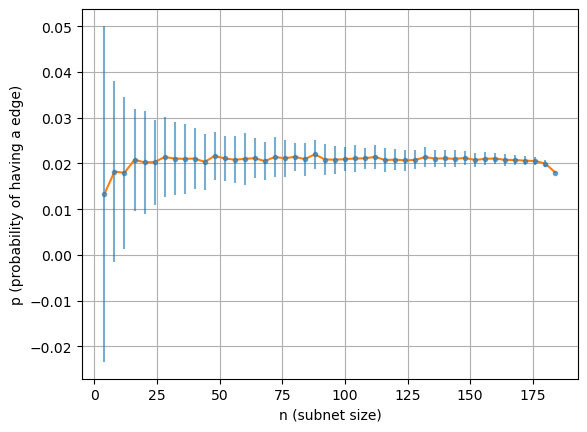

In [177]:

plt.errorbar(ns, np.mean(samples, axis=1), np.std(samples, axis=1), linestyle='None', marker='.', alpha=.6)
plt.plot(ns, np.mean(samples, axis=1), alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.grid()

In [182]:
samples2 = np.zeros((ns.shape[0], repeats))
for i, n in enumerate(ns):
    for r in range(repeats):
        s = sample_a_subnet(A, n)
        p = find_p(s, exclude_self_regulations=False)
        samples2[i, r] = p

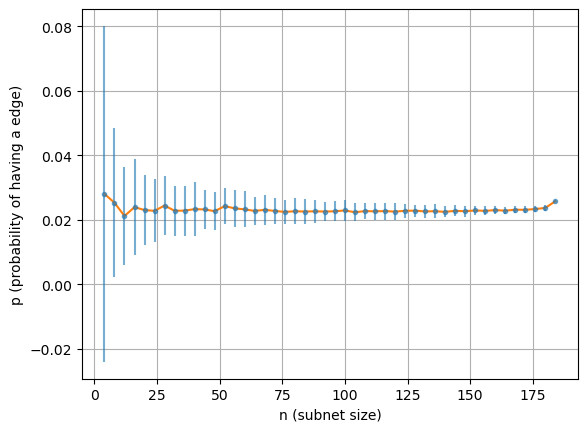

In [183]:
plt.errorbar(ns, np.mean(samples2, axis=1), np.std(samples2, axis=1), linestyle='None', marker='.', alpha=.6)
plt.plot(ns, np.mean(samples2, axis=1), alpha=1)
plt.xlabel("n (subnet size)")
plt.ylabel("p (probability of having a edge)")
plt.grid()